In [300]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Set plotting style
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')

## Dataset

In [301]:
df = pd.read_csv('datasets/tsla_2025.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')
df.head()

,Date,Open,High,Low,Close,Volume
0,2010-06-28,1.13333,1.13333,1.13333,1.13333,0
1,2010-06-29,1.26667,1.66667,1.16933,1.59267,281749140
2,2010-06-30,1.71933,2.02800,1.55333,1.58867,257915910
3,2010-07-01,1.66667,1.72800,1.35133,1.46400,123447945
4,2010-07-02,1.53333,1.54000,1.24733,1.28000,77127105


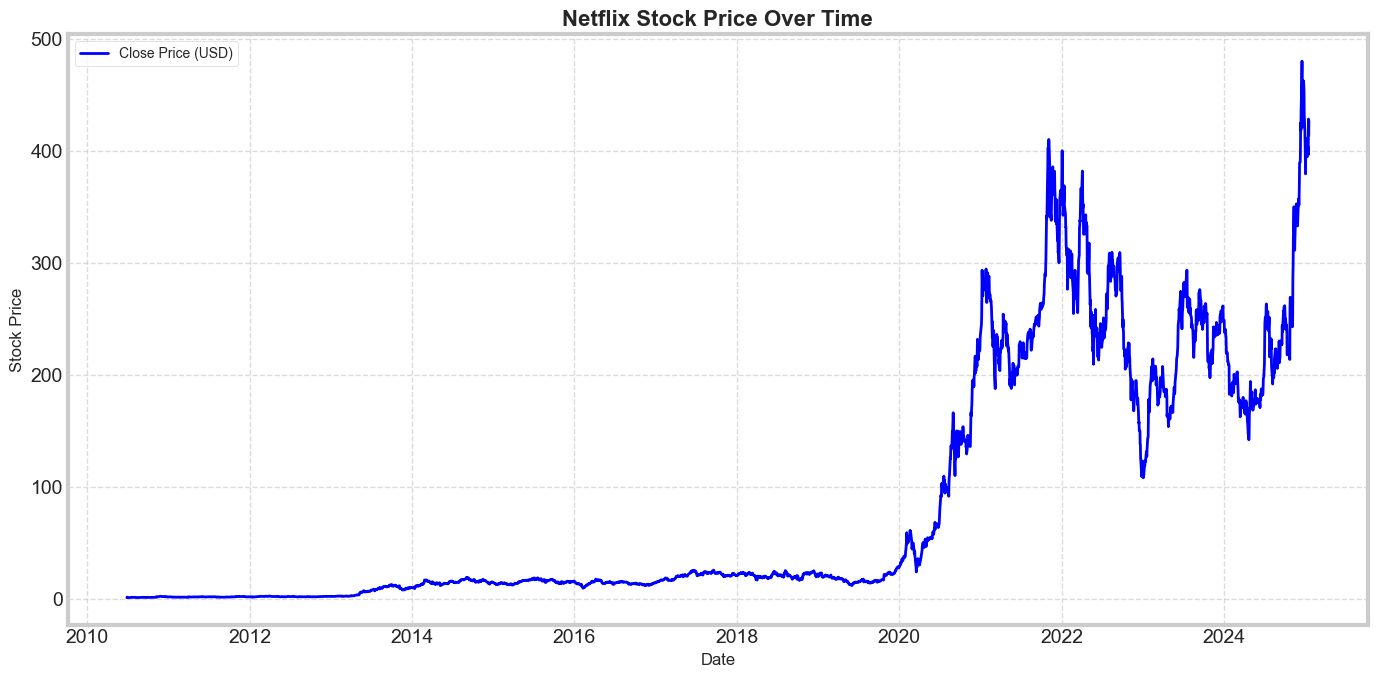

In [302]:
# Plotting the stock price over time
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Close'], label='Close Price (USD)', color='blue', linewidth=2)

# Enhance the title and labels
plt.title('Netflix Stock Price Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Stock Price', fontsize=12)

# Customize the legend
plt.legend(loc='upper left', fontsize=10)

# Add grid lines for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

## Add features for improved model

### Moving Average (MA)

ค่าเฉลี่ยเคลื่อนที่ ช่วยดูแนวโน้มราคา

In [303]:
df["MA5"] = df["Close"].rolling(window=5).mean()
df["MA10"] = df["Close"].rolling(window=10).mean()
df["MA50"] = df["Close"].rolling(window=50).mean()

### Relative Strength Index (RSI)

วัดว่าหุ้นอยู่ในโซน Overbought (>70) หรือ Oversold (<30)

In [304]:
# ตรวจสอบฟังก์ชัน calculate_rsi
def calculate_rsi(prices, window=14):
    """คำนวณ RSI อย่างปลอดภัย โดยตรวจสอบขนาดข้อมูลก่อน"""
    if len(prices) < window + 1:
        # ถ้าข้อมูลไม่พอ ส่งคืนค่า default
        return 50
    
    # คำนวณการเปลี่ยนแปลงราคา
    delta = prices.diff().dropna()
    
    # แยกเป็น gain (บวก) และ loss (ลบ)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    # คำนวณค่าเฉลี่ยเคลื่อนที่
    avg_gain = gain.rolling(window=window).mean().dropna()
    avg_loss = loss.rolling(window=window).mean().dropna()
    
    # ตรวจสอบความยาวของข้อมูลหลังจาก dropna
    if len(avg_gain) == 0 or len(avg_loss) == 0:
        return 50
    
    # ป้องกันการหารด้วยศูนย์
    rs = avg_gain.iloc[-1] / max(avg_loss.iloc[-1], 0.001)
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

df["RSI14"] = calculate_rsi(df["Close"])

### MACD (Moving Average Convergence Divergence)

วัดโมเมนตัมของราคา

In [305]:
df["EMA12"] = df["Close"].ewm(span=12, adjust=False).mean()
df["EMA26"] = df["Close"].ewm(span=26, adjust=False).mean()
df["MACD"] = df["EMA12"] - df["EMA26"]
df["Signal_Line"] = df["MACD"].ewm(span=9, adjust=False).mean()

### Lag Features (ราคาย้อนหลัง)

ราคาปิดย้อนหลัง 1, 2, 3 วัน

In [306]:
df["Close_Lag1"] = df["Close"].shift(1)
df["Close_Lag2"] = df["Close"].shift(2)
df["Close_Lag3"] = df["Close"].shift(3)

### Volatility (Rolling Standard Deviation)

ความผันผวนของราคาช่วง 10 วัน

In [307]:
df["Volatility"] = df["Close"].rolling(window=10).std()

### Rate of Change (ROC)

อัตราการเปลี่ยนแปลงของราคาในช่วง 10 วัน

In [308]:
df["ROC"] = df["Close"].pct_change(periods=10) * 100

In [309]:
# ลบค่าที่เป็น NaN (เกิดจาก rolling window)
df = df.dropna()

df.tail()

,Date,Open,High,Low,Close,Volume,MA5,MA10,MA50,RSI14,EMA12,EMA26,MACD,Signal_Line,Close_Lag1,Close_Lag2,Close_Lag3,Volatility,ROC
3658,2025-01-13,383.21,403.79,380.070,403.31,67580494,399.680,404.103,367.9020,43.042055,407.132760,400.501572,6.631188,14.671622,394.74,394.94,394.36,14.561420,-11.190628
3659,2025-01-14,414.34,422.64,394.540,396.36,84565022,396.742,400.573,370.6782,43.042055,405.475413,400.194789,5.280624,12.793423,403.31,394.74,394.94,10.976092,-8.177732
3660,2025-01-15,409.90,429.80,405.661,428.22,81375460,403.514,401.654,374.2456,43.042055,408.974580,402.270730,6.703850,11.575508,396.36,403.31,394.74,13.137977,2.589780
3661,2025-01-16,423.49,424.00,409.130,413.82,68335151,407.290,402.652,377.5424,43.042055,409.720029,403.126232,6.593797,10.579166,428.22,396.36,403.31,13.689943,2.471276
3662,2025-01-17,421.50,439.74,419.750,426.50,94991429,413.642,407.374,381.2156,43.042055,412.301563,404.857622,7.443941,9.952121,413.82,428.22,396.36,12.850571,12.449905


## Tesla Stock Price Prediction

### Gradient Boosting Regression

In [310]:
class GradientBoostingRegressor:
    def __init__(self, n_trees=100, learning_rate=0.1, max_depth=4):
        # Set the number of trees (n_trees), learning rate (learning_rate),
        # and maximum depth (max_depth) of the trees
        self.n_trees = n_trees
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.trees = []
        self.H = None
        
    def _negative_gradient(self, y, H):
        # Calculate the negative gradient by computing residual = y (true value) - H (current estimate)
        return y - H
    
    def _build_tree(self, X, y, depth=0):
        # Build a decision tree to model the residuals for prediction
        if depth >= self.max_depth or len(set(y)) == 1:
            # If we reach the maximum depth or the target values are all the same,
            # make a leaf node using the mean value
            return np.mean(y)
        
        best_feature, best_threshold, best_mse = None, None, float('inf')
        best_split = None
        
        # Number of thresholds to sample
        n_thresholds = 30
        # Number of features
        n_features = X.shape[1]
        
        # Loop through each feature to find the best threshold
        for feature_idx in range(n_features):
            unique_vals = np.unique(X[:, feature_idx])
            # If there are many unique values, randomly sample a subset
            if len(unique_vals) > n_thresholds:
                sampled_thresholds = np.random.choice(unique_vals, n_thresholds, replace=False)
            else:
                sampled_thresholds = unique_vals
            
            # Test each threshold and pick the one with the lowest MSE
            for threshold in sampled_thresholds:
                left_mask = X[:, feature_idx] <= threshold
                right_mask = ~left_mask
                
                if not np.any(left_mask) or not np.any(right_mask):
                    # Skip if one side does not have any data
                    continue
                
                y_left, y_right = y[left_mask], y[right_mask]
                left_mean, right_mean = np.mean(y_left), np.mean(y_right)
                mse = (np.mean((y_left - left_mean) ** 2) +
                       np.mean((y_right - right_mean) ** 2))
                
                if mse < best_mse:
                    best_mse = mse
                    best_feature = feature_idx
                    best_threshold = threshold
                    best_split = (left_mask, right_mask)
    
        # If no split was found, return the mean value
        if best_split is None:
            return np.mean(y)
        
        # Split the data into left and right subsets and build subtrees
        left_subtree = self._build_tree(X[best_split[0]], y[best_split[0]], depth + 1)
        right_subtree = self._build_tree(X[best_split[1]], y[best_split[1]], depth + 1)
        
        # Return the tree structure as (feature, threshold, left_subtree, right_subtree)
        return (best_feature, best_threshold, left_subtree, right_subtree)
    
    def _predict_tree(self, tree, x):
        # Predict a value using the built tree
        if isinstance(tree, (int, float)):
            # If the tree is just a number, it's a leaf node
            return tree
        
        feature, threshold, left_subtree, right_subtree = tree
        # Move to the left subtree if x[feature] <= threshold, otherwise move to the right subtree
        if x[feature] <= threshold:
            return self._predict_tree(left_subtree, x)
        else:
            return self._predict_tree(right_subtree, x)
        
    def fit(self, X, y):
        # Initialize H with the mean of y
        mean_y = np.mean(y)
        self.H = np.full(y.shape, mean_y)
        
        # Use tqdm to show a progress bar
        with tqdm(total=self.n_trees, desc="Training Progress", unit="tree") as pbar:
            for _ in range(self.n_trees):
                # Compute residuals (negative gradient)
                residuals = self._negative_gradient(y, self.H)
                
                # Build a tree to predict the residuals
                tree = self._build_tree(X, residuals)
                self.trees.append(tree)
                
                # Update the current estimate H using the new tree
                for i in range(len(X)):
                    self.H[i] += self.learning_rate * self._predict_tree(tree, X[i])
                
                pbar.update(1)
                
    def predict(self, X):
        # Create an array for predictions, initialized with the mean of H
        predictions = np.full(X.shape[0], np.mean(self.H))
        # Add the predictions from each tree, scaled by the learning rate
        for tree in self.trees:
            for i in range(len(X)):
                predictions[i] += self.learning_rate * self._predict_tree(tree, X[i])
        return predictions

### Training a Model

In [311]:
# Features and Targets
X = df[[col for col in df.columns if col not in ['Close', 'Date', 'High', 'Low', 'Volumn']]].values
y = df['Close'].values

# Split into training and testing sets
train_size = int(len(X) * 0.9)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (3252, 15)
X_test shape: (362, 15)


In [312]:
# Train the model
gbrt = GradientBoostingRegressor(n_trees=200, learning_rate=0.05, max_depth=4)
gbrt.fit(X_train, y_train)

Training Progress: 100%|██████████| 200/200 [00:42<00:00,  4.73tree/s]


In [313]:
# Make predictions on the testing set
y_pred = gbrt.predict(X_test)

# Calculate the mean squared error
mse = np.mean((y_pred - y_test) ** 2)
print(f"Mean squared error: {mse:.4f}")

Mean squared error: 772.6033


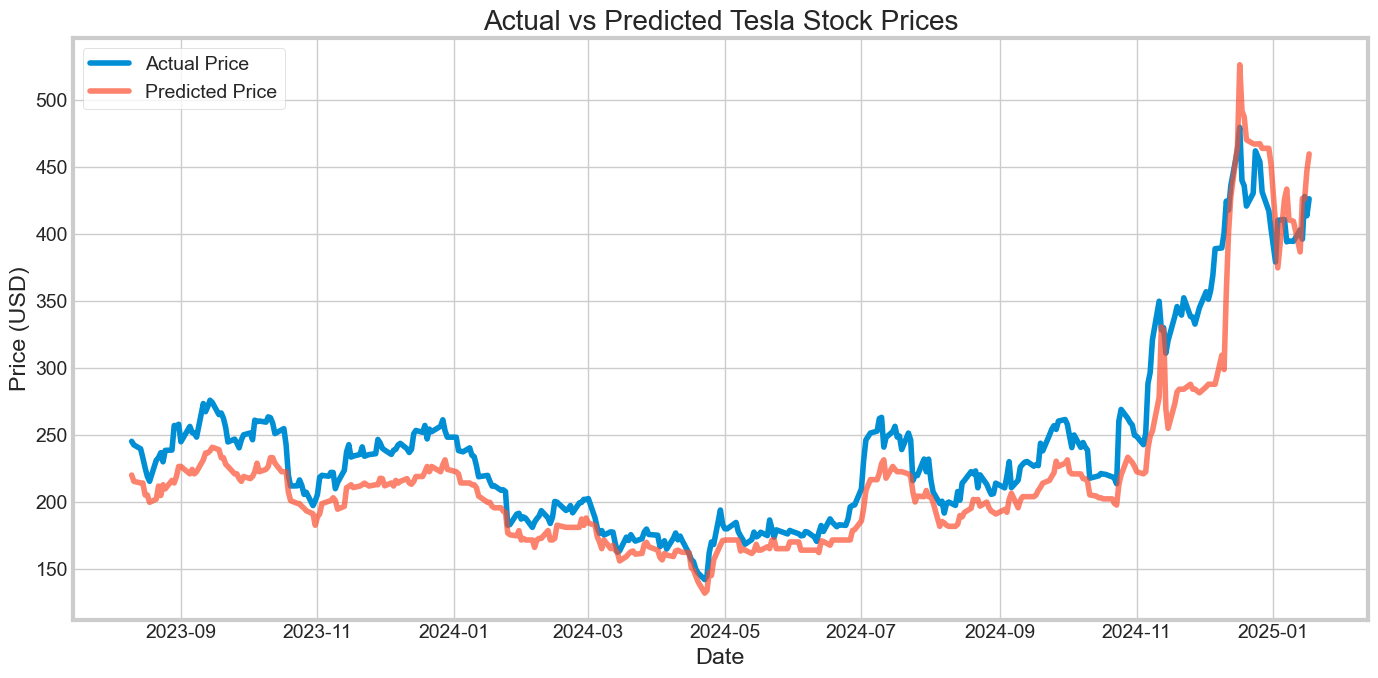

In [314]:
# Plot actual vs predicted prices
plt.figure(figsize=(14, 7))
plt.title('Actual vs Predicted Tesla Stock Prices')
plt.plot(df['Date'].iloc[-len(y_test):], y_test, label='Actual Price')
plt.plot(df['Date'].iloc[-len(y_test):], y_pred, label='Predicted Price', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Predicts the price of Tesla stock

In [315]:
# Number of days to forecast
forecast_days = 60

# Copy the current dataframe
df_forecast = df.copy()
forecast_start_idx = len(df_forecast)

for i in range(forecast_days):
    new_row = pd.DataFrame({col: [np.nan] for col in df.columns})
    new_row['Date'] = df['Date'].max() + pd.Timedelta(days=i+1)
    
    # ใช้ข้อมูลล่าสุดจาก df_forecast เสมอ
    new_row['MA5'] = df_forecast['Close'].tail(5).mean()
    new_row['MA10'] = df_forecast['Close'].tail(10).mean()
    new_row['MA50'] = df_forecast['Close'].tail(50).mean()
    
    new_row["RSI14"] = calculate_rsi(df_forecast["Close"])
    
    new_row['EMA12'] = df_forecast['Close'].ewm(span=12, adjust=False).mean().iloc[-1]
    new_row['EMA26'] = df_forecast['Close'].ewm(span=26, adjust=False).mean().iloc[-1]
    new_row['MACD'] = new_row['EMA12'] - new_row['EMA26']
    new_row['Signal_Line'] = df_forecast['MACD'].ewm(span=9, adjust=False).mean().iloc[-1]
    
    new_row['Close_Lag1'] = df_forecast['Close'].iloc[-1]  
    new_row['Close_Lag2'] = df_forecast['Close'].iloc[-2]
    new_row['Close_Lag3'] = df_forecast['Close'].iloc[-3]
    
    # คำนวณ volatility และ ROC จากข้อมูลล่าสุด
    new_row['Volatility'] = df_forecast['Close'].tail(10).std()
    new_row['ROC'] = df_forecast['Close'].pct_change(periods=10).iloc[-1] * 100
    
    for feature in ['MA5', 'MA10', 'MA50', 'RSI14', 'Volatility']:
      if feature in new_row.columns:
        noise = np.random.normal(0, 0.001 * new_row[feature].iloc[0])
        new_row[feature] = new_row[feature].iloc[0] + noise
    
    # ทำนายและบันทึกผล
    X_forecast = new_row[[col for col in df.columns if col not in ['Close', 'Date', 'High', 'Low', 'Volumn']]].values
    new_row['Close'] = gbrt.predict(X_forecast)[0]
    df_forecast = pd.concat([df_forecast, new_row], ignore_index=True)

df_forecast.tail(10)

,Date,Open,High,Low,Close,Volume,MA5,MA10,MA50,RSI14,EMA12,EMA26,MACD,Signal_Line,Close_Lag1,Close_Lag2,Close_Lag3,Volatility,ROC
3664,2025-03-09,NaN,NaN,NaN,466.129360,NaN,466.335808,463.051780,463.069316,50.108182,464.268329,462.648161,1.620168,1.802499,466.129360,466.129360,466.129360,8.703194,0.000000
3665,2025-03-10,NaN,NaN,NaN,466.129360,NaN,466.581690,463.454613,464.307903,49.996497,464.554641,462.906027,1.648614,1.766033,466.129360,466.129360,466.129360,8.723969,0.000000
3666,2025-03-11,NaN,NaN,NaN,466.129360,NaN,466.567236,463.937081,464.100102,50.048799,464.796906,463.144793,1.652113,1.742549,466.129360,466.129360,466.129360,8.707223,0.000000
3667,2025-03-12,NaN,NaN,NaN,466.129360,NaN,465.763380,463.546293,464.069453,50.104811,465.001898,463.365872,1.636027,1.724462,466.129360,466.129360,466.129360,8.710978,0.000000
3668,2025-03-13,NaN,NaN,NaN,438.588901,NaN,466.335091,466.398150,464.421057,49.973234,465.175354,463.570574,1.604780,1.706775,466.129360,466.129360,466.129360,0.000000,6.279333
3669,2025-03-14,NaN,NaN,NaN,466.129360,NaN,460.749509,464.539494,462.214121,33.398267,461.085130,461.720080,-0.634950,1.686376,438.588901,466.129360,466.129360,8.708019,-5.908329
3670,2025-03-15,NaN,NaN,NaN,466.129360,NaN,460.514570,463.281288,463.485675,50.033153,461.861166,462.046693,-0.185528,1.222111,466.129360,438.588901,466.129360,8.707405,0.000000
3671,2025-03-16,NaN,NaN,NaN,466.129360,NaN,460.713910,464.313513,462.912445,50.112674,462.517811,462.349113,0.168698,0.940583,466.129360,466.129360,438.588901,8.715887,0.000000
3672,2025-03-17,NaN,NaN,NaN,466.129360,NaN,461.149067,463.322154,462.063252,66.466447,463.073434,462.629131,0.444302,0.786206,466.129360,466.129360,466.129360,8.704618,0.000000
3673,2025-03-18,NaN,NaN,NaN,466.129360,NaN,459.965545,463.109754,463.825207,49.963764,463.543576,462.888407,0.655169,0.717825,466.129360,466.129360,466.129360,8.713909,0.000000


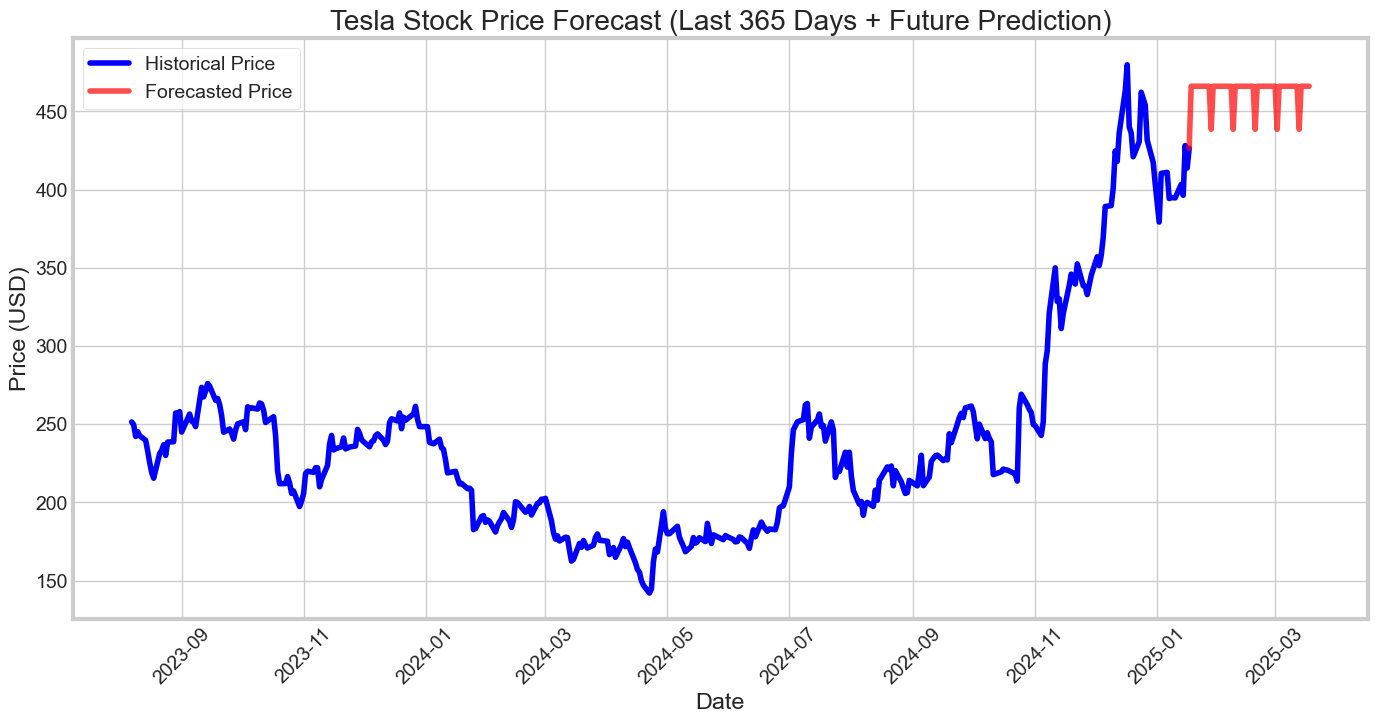

In [316]:
# Plot the forecasted prices with only the last 365 days of historical data
plt.figure(figsize=(14, 7))
plt.title('Tesla Stock Price Forecast (Last 365 Days + Future Prediction)')

# Calculate the start index for showing only last 365 days of historical data
historical_start_idx = max(0, forecast_start_idx - 365)

# Historical price data (last 365 days only)
plt.plot(df_forecast['Date'][historical_start_idx:forecast_start_idx], 
     df_forecast['Close'][historical_start_idx:forecast_start_idx], 
     label='Historical Price', color='blue')

# Forecasted price data
plt.plot(df_forecast['Date'][forecast_start_idx-1:], 
     df_forecast['Close'][forecast_start_idx-1:], 
     label='Forecasted Price', color='red', alpha=0.7)

plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()